In [1]:
import numpy as np
%matplotlib inline
import pprint
import os

In [2]:
# import pymatgen.core

In [3]:
import pandas as pd
import pathlib

In [4]:
# current working directory
print(pathlib.Path().absolute())

/home/samariam/projects/synth/heuristics_analysis


In [6]:
# new_labels_path = '/home/samariam/projects/chemheuristics/data/schnet_0.pkl'
# labeldf = pd.read_pickle('old_schnet_o.pkl')

Schent results

In [15]:
crysdf = pd.read_pickle('/home/samariam/projects/chemheuristics/reports/1st_fulldata_schnet_alignn/fullData0_100ep15')

In [16]:
if (crysdf.shape[0]-crysdf.groupby("material_id").first().shape[0])/crysdf.shape[0] <0.01:
    crysdf = crysdf.groupby("material_id").first()
else:
    print("We have duplicate data.")    

In [17]:
sum(crysdf.target_pd==1)

10281

In [18]:
crysdf.columns

Index(['crystal_id', 'atoms', 'theoretical', 'formation_energy_per_atom',
       'energy_above_hull', 'target_pd', 'targets', 'pred_0', 'pred_1',
       'pred_2',
       ...
       'pred_90', 'pred_91', 'pred_92', 'pred_93', 'pred_94', 'pred_95',
       'pred_96', 'pred_97', 'pred_98', 'pred_99'],
      dtype='object', length=107)

In [19]:
crysdf = crysdf[crysdf.formation_energy_per_atom>-10]   #dropping outlier from outdated database.
crysdf = crysdf[crysdf.energy_above_hull<10]   #dropping outliers for better visualization.

In [20]:
crysdf.shape

(41962, 107)

In [21]:
pred_columns = []
score_columns = []
num_iter =100
epoch_num = 15
for it in range(num_iter):
    pred_col_name = 'pred_'+str(it)
    pred_columns.append(pred_col_name)
    
    # score_col_name = 'pred_score'+str(it)
    # score_columns.append(score_col_name)

Preds = crysdf[pred_columns]

In [22]:
Preds.head(2)

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,...,pred_90,pred_91,pred_92,pred_93,pred_94,pred_95,pred_96,pred_97,pred_98,pred_99
material_id,,,,,,,,,,,,,,,,,,,,,
1607,0.0,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0
1609,1.0,NaN,1.0,1.0,0.0,0.0,1.0,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0


In [23]:
def scoreFunc(x):
    iter_num = sum(x.notna())
    if iter_num == 0:
        return np.nan, iter_num
    res = x.sum()
    score = res/iter_num
    return score, iter_num

In [24]:
crysdf['Preds'] = Preds.apply(scoreFunc, axis=1)

crysdf[['Preds', 'iter_num']] = crysdf.Preds.tolist()

# res_df = crysdf[crysdf.Preds.notna()].drop(columns=[*pred_columns,*score_columns])  #selecting data with prediction values
res_df = crysdf[crysdf.Preds.notna()].drop(columns=[*pred_columns])  #selecting data with prediction values

experimental_df = res_df[res_df.target_pd==1]
theoretical_df = res_df[res_df.target_pd==0]

# %%
true_positive_rate = sum(experimental_df.Preds>=.5)/experimental_df.shape[0]
unlabeled_synth_frac = sum(theoretical_df.Preds>=.5)/theoretical_df.shape[0]

In [25]:
print('Our true positive rate is {:.1f}% after {} iterations of {} epochs.'.format(true_positive_rate*100, num_iter, epoch_num))

Our true positive rate is 80.2% after 100 iterations of 15 epochs.


In [26]:
unlabeled_synth_frac

0.018812537483033995

In [27]:
crysdf.columns

Index(['crystal_id', 'atoms', 'theoretical', 'formation_energy_per_atom',
       'energy_above_hull', 'target_pd', 'targets', 'pred_0', 'pred_1',
       'pred_2',
       ...
       'pred_92', 'pred_93', 'pred_94', 'pred_95', 'pred_96', 'pred_97',
       'pred_98', 'pred_99', 'Preds', 'iter_num'],
      dtype='object', length=109)

In [28]:
cotrain_df = crysdf[['target_pd', 'Preds']]

In [29]:
cotrain_df.loc[:,"prediction"] = cotrain_df.Preds.map(lambda x: 1 if x>.5 else 0)

/tmp/ipykernel_415909/3212071970.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cotrain_df.loc[:,"prediction"] = cotrain_df.Preds.map(lambda x: 1 if x>.5 else 0)


In [30]:
cotrain_df = cotrain_df.rename(columns = {"target_pd":"original_target"})

In [31]:
cotrain_df.head(3)

,original_target,Preds,prediction
material_id,,,
1607,0,0.041667,0
1609,0,0.053333,0
1612,0,0.196970,0


In [32]:
# new_labels_path = '/home/samariam/projects/chemheuristics/data/schnet_0.pkl'
# cotrain_df = pd.read_pickle(new_labels_path)
cotrain_df.set_index(cotrain_df.index.map(str), drop=True, inplace=True)
if not (set([type(i) for i in cotrain_df.index]) == {str}):
    print("Your indexes are not properly formatted strings!")

In [12]:
# cotrain_df.head(5)
new_labels_path = '/home/samariam/projects/chemheuristics/data/schnet_0.pkl'
cotrain_df.to_pickle(new_labels_path)

In [17]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [18]:
edf = experimental_df.copy()
del experimental_df
tdf = theoretical_df.copy()
del theoretical_df

In [19]:
len(tdf), len(edf)

(31681, 10281)

In [20]:
# edf.head(2)
# tdf.head(2)

In [20]:
edf['classPred'] = edf.Preds.map(lambda x: 1 if x>.5 else 0)
tdf['classPred'] = tdf.Preds.map(lambda x: 1 if x>.5 else 0)

In [24]:
figpath = "/home/samariam/projects/chemheuristics/reports/1st_fulldata_schnet_alignn"

In [25]:
figpath

'/home/samariam/projects/chemheuristics/reports/1st_fulldata_schnet_alignn'

In [26]:
nonzero_pred = tdf[(tdf.Preds>0.01) & (tdf.Preds<0.5)]

In [27]:
len(nonzero_pred)/len(tdf)

0.3124270067232726

/tmp/ipykernel_3890500/2514944773.py:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(212,  sharex=ax1,)


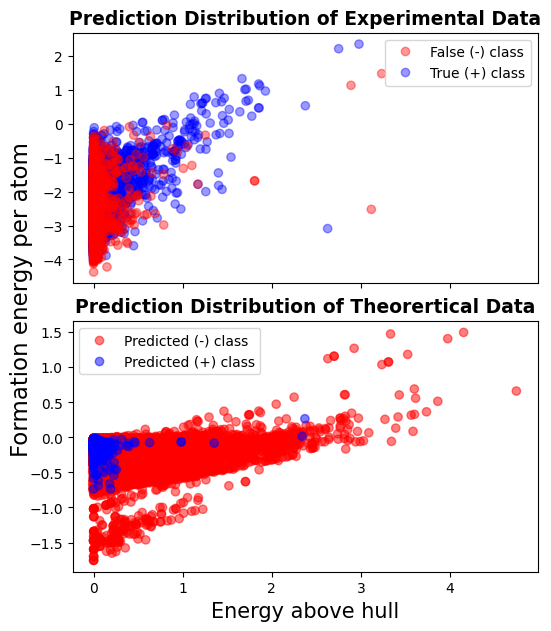

In [24]:
data_classes_e = ['False (-) class', 'True (+) class']
data_classes_t = ['Predicted (-) class', 'Predicted (+) class']

colors = ListedColormap(['r','b'])
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6,7))

scatter  = ax1.scatter(edf.sort_values("Preds", ascending=False).energy_above_hull, 
            edf.sort_values("Preds", ascending=False).formation_energy_per_atom,
            c=edf.sort_values("Preds", ascending=False).classPred, 
            cmap = colors,alpha = .4)
ax1.legend(handles=scatter.legend_elements()[0], labels=data_classes_e)

ax1.set_title('Prediction Distribution of Experimental Data', fontsize=13.5, fontweight='bold')
plt.tick_params('x', labelbottom=False);

ax2 = plt.subplot(212,  sharex=ax1,)
scatter  = plt.scatter(tdf.sort_values("Preds", ascending=True).energy_above_hull, 
            tdf.sort_values("Preds", ascending=True).formation_energy_per_atom,
            c=tdf.sort_values("Preds", ascending=True).classPred, 
            cmap = colors,alpha = .5)

ax2.legend(handles=scatter.legend_elements()[0], labels=data_classes_t)

ax2.set_xlabel('Energy above hull', fontsize=15)
# ax2.set_ylabel('Formation energy per atom', fontsize=12)
ax2.set_title('Prediction Distribution of Theorertical Data', fontsize=13.5, fontweight='bold');

plt.subplots_adjust(hspace=.15)
fig.text(0.04, 0.5, 'Formation energy per atom', ha='center', va='center',
         rotation='vertical', fontsize=16.5);

# plt.savefig('energies_labels_double.jpg', format='jpg',
plt.savefig('energies_labels_double_100epoch.jpg', format='jpg',
            bbox_inches='tight',dpi=400);


In [25]:
os.getcwd()

'/home/samariam/projects/chemheuristics/reports/1st_fulldata_schnet_alignn'

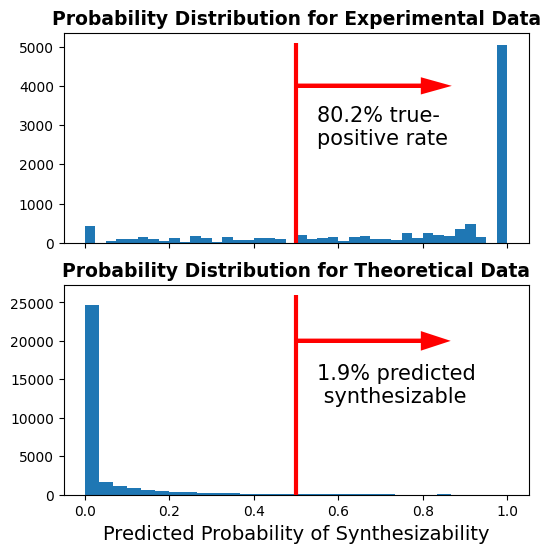

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6,6))

ax1.hist(edf.Preds, bins=40)
# edf.Preds.hist(bins=40)
ax1.set_title('Probability Distribution for Experimental Data', fontsize=13.5, fontweight='bold')
ax1.vlines(.5, 0,5100, 'r',linewidth=3)
ax1.arrow(.5,4000,.35,0, linewidth=3, color ='r', length_includes_head=True,
          head_width=300, head_length=0.05)
ax1.text(.55,2500, '{:.1f}% true- \npositive rate'.format(true_positive_rate*100), fontsize = 15);


plt.xlabel('Predicted Probability of Synthesizability', fontsize=14)

ax2.hist(tdf.Preds,bins=30)
ax2.vlines(.5, 0,26000, 'r',linewidth=3)
ax2.arrow(.5,20000,.35,0, linewidth=3, color ='r', length_includes_head=True,
          head_width=1800, head_length=0.05)
ax2.set_title('Probability Distribution for Theoretical Data', fontsize=13.5,fontweight='bold')
ax2.text(.55,12000, '{:.1f}% predicted \n synthesizable'.format(unlabeled_synth_frac*100), fontsize = 15);


# plt.savefig('prob_dist_double.jpg',format='jpg',
plt.savefig('prob_dist_double_100epoch.jpg',format='jpg',
            bbox_inches='tight',dpi=400);


In [27]:
dynamictruePosRates= []
dynamicPredictPosRates = []
never_positive_rate = sum(tdf.Preds==0)/len(tdf)
plot_range = np.linspace(0,1, 25)
for i in plot_range:
    edf['dynamicPred'] = edf.Preds.map(lambda x: 1 if x>i else 0)
    tdf['dynamicPred'] = tdf.Preds.map(lambda x: 1 if x>i else 0)
    dtpr = sum(edf['dynamicPred'])/len(edf)
    dynamictruePosRates.append(dtpr*100)
    dppr = sum(tdf['dynamicPred'])/len(tdf)
    dynamicPredictPosRates.append(dppr*100)
    

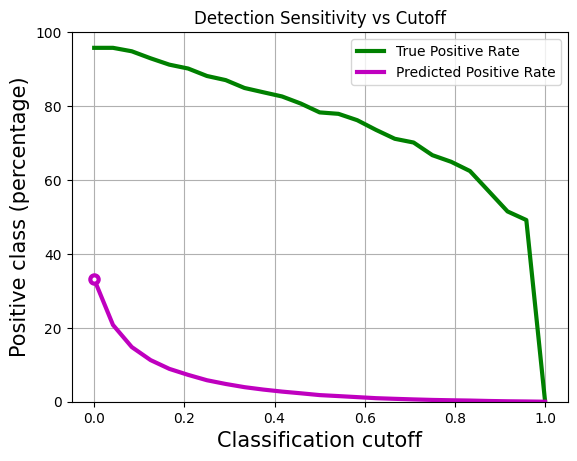

In [28]:
plt.plot(plot_range, dynamictruePosRates, "g", linewidth=3, label ="True Positive Rate")
l, =plt.plot(plot_range, dynamicPredictPosRates,"m", linewidth=3, label ="Predicted Positive Rate")
plt.scatter(plot_range[0], dynamicPredictPosRates[0], marker='o', 
    facecolor='white',  # Change: to opaque color
    edgecolor=l.get_color(),  
    linewidth=l.get_linewidth(),  # Change: match line width
    zorder=10  # Change: raise to higher level.
    )
plt.ylim(0, 100)
plt.grid()
plt.xlabel("Classification cutoff", fontsize = 15)
plt.ylabel("Positive class (percentage)", fontsize = 15)
plt.title("Detection Sensitivity vs Cutoff")
plt.legend()
plt.savefig('detection_sensitivity_cutoff.jpg', format='jpg',
            bbox_inches='tight',dpi=400);
# ;

In [63]:
tdf.Preds.head()

material_id
1607    0.041667
1609    0.053333
1612    0.196970
1618    0.000000
1623    0.038462
Name: Preds, dtype: float64

In [64]:
[5]*3

[5, 5, 5]

In [65]:
tdf["mid_class_pred_sch"] = tdf.classPred.copy()
tdf.mid_class_pred_sch[(tdf.Preds>0.01) & (tdf.Preds<0.5)] = 0.5

/tmp/ipykernel_3732359/1272160428.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf.mid_class_pred_sch[(tdf.Preds>0.01) & (tdf.Preds<0.5)] = 0.5


/tmp/ipykernel_3890500/1667690780.py:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(  sharex=ax1,)


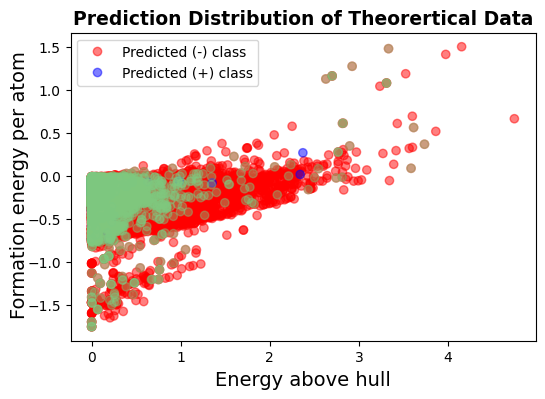

In [35]:
# data_classes_e = ['False (-) class', 'True (+) class']
# data_classes_t = ['Predicted (-) class', 'Predicted (+) class']

# colors = ListedColormap(['r','b'])
# fig, ax2 = plt.subplots(1, 1, sharex=True, figsize=(6,4))

# # scatter  = ax1.scatter(edf.sort_values("Preds", ascending=False).energy_above_hull, 
# #             edf.sort_values("Preds", ascending=False).formation_energy_per_atom,
# #             c=edf.sort_values("Preds", ascending=False).classPred, 
# #             cmap = colors,alpha = .4)
# # ax1.legend(handles=scatter.legend_elements()[0], labels=data_classes_e)

# # ax1.set_title('Prediction Distribution of Experimental Data', fontsize=13.5, fontweight='bold')
# # plt.tick_params('x', labelbottom=False);

# ax2 = plt.subplot(  sharex=ax1,)
# scatter  = plt.scatter(tdf.sort_values("Preds", ascending=True).energy_above_hull, 
#             tdf.sort_values("Preds", ascending=True).formation_energy_per_atom,
#             c=tdf.sort_values("Preds", ascending=True).classPred, 
#             cmap = colors,alpha = .5)
# scatter2  = plt.scatter(nonzero_pred.sort_values("Preds", ascending=False).energy_above_hull, 
#             nonzero_pred.sort_values("Preds", ascending=False).formation_energy_per_atom,
#             c=nonzero_pred.sort_values("Preds", ascending=False).classPred, 
#             cmap = "Accent",alpha = .4)
# ax2.legend(handles=scatter.legend_elements()[0], labels=data_classes_t)

# ax2.set_xlabel('Energy above hull', fontsize=14)
# # ax2.set_ylabel('Formation energy per atom', fontsize=12)
# ax2.set_title('Prediction Distribution of Theorertical Data', fontsize=13.5, fontweight='bold');

# plt.subplots_adjust(hspace=.15)
# fig.text(0.04, 0.5, 'Formation energy per atom', ha='center', va='center',
#          rotation='vertical', fontsize=14);

# # plt.savefig('energies_labels_double.jpg', format='jpg',
# plt.savefig('energies_labels_non_negative_labels.jpg', format='jpg',
#             bbox_inches='tight',dpi=400);


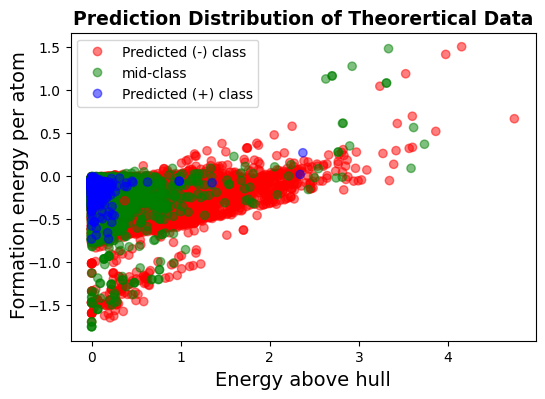

In [66]:

data_classes_t = ['Predicted (-) class', 'mid-class', 'Predicted (+) class']


colors = ListedColormap(['r','g','b'])
fig, ax2 = plt.subplots(1, 1, sharex=True, figsize=(6,4))


scatter  = plt.scatter(tdf.sort_values("Preds", ascending=True).energy_above_hull, 
            tdf.sort_values("Preds", ascending=True).formation_energy_per_atom,
            c=tdf.sort_values("Preds", ascending=True).mid_class_pred_sch, 
            cmap = colors,alpha = .5)
# scatter2  = plt.scatter(nonzero_pred.sort_values("Preds", ascending=False).energy_above_hull, 
#             nonzero_pred.sort_values("Preds", ascending=False).formation_energy_per_atom,
#             c=nonzero_pred.sort_values("Preds", ascending=False).classPred, 
#             cmap = "Accent",alpha = .4)
ax2.legend(handles=scatter.legend_elements()[0], labels=data_classes_t)

ax2.set_xlabel('Energy above hull', fontsize=14)
# ax2.set_ylabel('Formation energy per atom', fontsize=12)
ax2.set_title('Prediction Distribution of Theorertical Data', fontsize=13.5, fontweight='bold');

plt.subplots_adjust(hspace=.15)
fig.text(0.04, 0.5, 'Formation energy per atom', ha='center', va='center',
         rotation='vertical', fontsize=14);

# plt.savefig('energies_labels_double.jpg', format='jpg',
# plt.savefig('energies_labels_non_negative_labels.jpg', format='jpg',
#             bbox_inches='tight',dpi=400);


<function PU_alignn_analysis.pu_report(output_dir: str = None)>

Alignn results

In [28]:
alignnraw = pd.read_pickle('/home/samariam/projects/chemheuristics/reports/1st_fulldata_schnet_alignn/puAlignnFullData_2.pkl')

In [29]:
alignndf = pd.DataFrame()
alignndf['avg_prediction_alignn'] = alignnraw.groupby('material_id').prediction.mean()
alignndf['prediction_alignn'] = alignndf['avg_prediction_alignn'].map(round)
alignndf['target'] = alignnraw.groupby('material_id').target.first()

In [30]:
crysdf.reset_index(inplace=True)
alignndf.reset_index(inplace=True)

In [31]:
for i in range(len(crysdf)):
    crysdf.material_id[i]=str(crysdf.material_id[i])

/tmp/ipykernel_3732359/3973468145.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crysdf.material_id[i]=str(crysdf.material_id[i])


In [41]:
alignndf.shape

(41975, 4)

In [32]:
bigdf = crysdf.merge(alignndf, on="material_id")

In [33]:
bigdf.drop(columns=Preds.columns, inplace=True)

In [34]:
bigdf.columns

Index(['material_id', 'crystal_id', 'atoms', 'theoretical',
       'formation_energy_per_atom', 'energy_above_hull', 'target_pd',
       'targets', 'Preds', 'iter_num', 'avg_prediction_alignn',
       'prediction_alignn', 'target'],
      dtype='object')

In [35]:
bigEdf = bigdf[bigdf['target']==1]
bigTdf = bigdf[bigdf['target']==0]

true_positive_rate_alignn = bigEdf['prediction_alignn'].sum()/len(bigEdf)
predicted_positive_rate_alignn = bigTdf['prediction_alignn'].sum()/len(bigTdf)

print("The true positive rate was", round(true_positive_rate_alignn,3))
print("The predicted positive rate for the unlabeled data was", round(predicted_positive_rate_alignn, 3))

The true positive rate was 0.829
The predicted positive rate for the unlabeled data was 0.173


In [36]:
# bigdf.head(3)

In [37]:
os.getcwd()

'/home/samariam/projects/chemheuristics/reports/1st_fulldata_schnet_alignn'

In [39]:
bigTdf.shape

(31681, 13)

/tmp/ipykernel_3732359/1536204740.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(212,  sharex=ax1,)


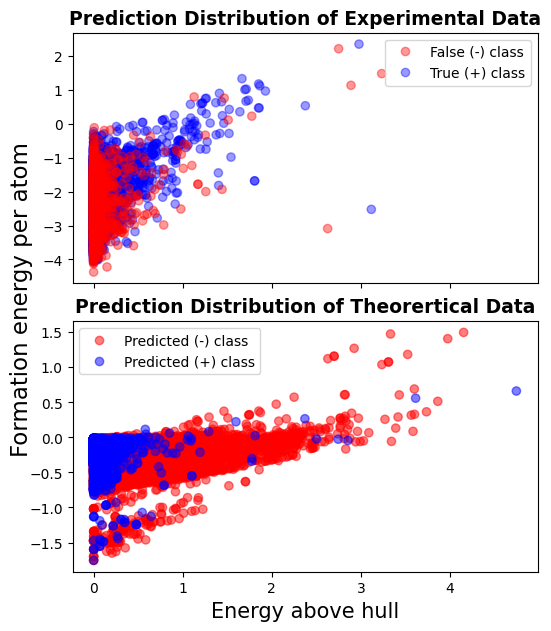

In [47]:
data_classes_e = ['False (-) class', 'True (+) class']
data_classes_t = ['Predicted (-) class', 'Predicted (+) class']

colors = ListedColormap(['r','b'])
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6,7))

scatter  = ax1.scatter(bigEdf.sort_values("avg_prediction_alignn", ascending=False).energy_above_hull, 
            bigEdf.sort_values("avg_prediction_alignn", ascending=False).formation_energy_per_atom,
            c=bigEdf.sort_values("avg_prediction_alignn", ascending=False).prediction_alignn, 
# scatter  = ax1.scatter(bigEdf.energy_above_hull, 
#             bigEdf.formation_energy_per_atom,
#             c=bigEdf.prediction_alignn, 
            cmap = colors,alpha = .4)
ax1.legend(handles=scatter.legend_elements()[0], labels=data_classes_e)

ax1.set_title('Prediction Distribution of Experimental Data', fontsize=13.5, fontweight='bold')
plt.tick_params('x', labelbottom=False);

ax2 = plt.subplot(212,  sharex=ax1,)
scatter  = plt.scatter(bigTdf.sort_values("avg_prediction_alignn", ascending=True).energy_above_hull, 
            bigTdf.sort_values("avg_prediction_alignn", ascending=True).formation_energy_per_atom,
            c=bigTdf.sort_values("avg_prediction_alignn", ascending=True).prediction_alignn, 
            cmap = colors,alpha = .5)

ax2.legend(handles=scatter.legend_elements()[0], labels=data_classes_t)

ax2.set_xlabel('Energy above hull', fontsize=15)
# ax2.set_ylabel('Formation energy per atom', fontsize=12)
ax2.set_title('Prediction Distribution of Theorertical Data', fontsize=13.5, fontweight='bold');

plt.subplots_adjust(hspace=.15)
fig.text(0.04, 0.5, 'Formation energy per atom', ha='center', va='center',
         rotation='vertical', fontsize=16.5);

# plt.savefig('energies_labels_double.jpg', format='jpg',
plt.savefig('energies_labels_alignn.jpg', format='jpg',
            bbox_inches='tight',dpi=400);


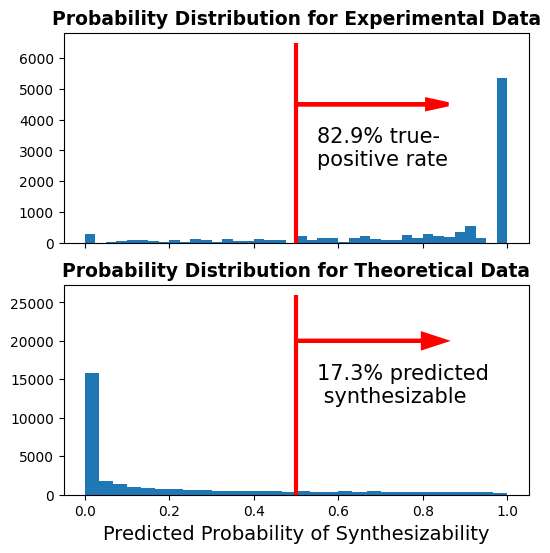

In [42]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6,6))

ax1.hist(bigEdf.avg_prediction_alignn, bins=40)
# edf.Preds.hist(bins=40)
ax1.set_title('Probability Distribution for Experimental Data', fontsize=13.5, fontweight='bold')
ax1.vlines(.5, 0,6500, 'r',linewidth=3)
ax1.arrow(.5,4500,.36,0, linewidth=3, color ='r', length_includes_head=True,
          head_width=300, head_length=0.05)
ax1.text(.55,2500, '{:.1f}% true- \npositive rate'.format(true_positive_rate_alignn*100), fontsize = 15);


plt.xlabel('Predicted Probability of Synthesizability', fontsize=14)

ax2.hist(bigTdf.avg_prediction_alignn,bins=30)
ax2.vlines(.5, 0,26000, 'r',linewidth=3)
ax2.arrow(.5,20000,.35,0, linewidth=3, color ='r', length_includes_head=True,
          head_width=1800, head_length=0.05)
ax2.set_title('Probability Distribution for Theoretical Data', fontsize=13.5,fontweight='bold')
ax2.text(.55,12000, '{:.1f}% predicted \n synthesizable'.format(predicted_positive_rate_alignn*100), fontsize = 15);


# plt.savefig('prob_dist_double.jpg',format='jpg',
plt.savefig('prob_dist_alignn.jpg',format='jpg',
            bbox_inches='tight',dpi=400);


In [43]:
dynamictruePosRatesAl= []
dynamicPredictPosRatesAl = []
never_positive_rate_Al = sum(bigTdf.avg_prediction_alignn==0)/len(bigTdf)
plot_range = np.linspace(0,1, 25)
for i in plot_range:
    bigEdf['dynamicPred'] = bigEdf.avg_prediction_alignn.map(lambda x: 1 if x>i else 0)
    bigTdf['dynamicPred'] = bigTdf.avg_prediction_alignn.map(lambda x: 1 if x>i else 0)
    dtpr = sum(bigEdf['dynamicPred'])/len(bigEdf)
    dynamictruePosRatesAl.append(dtpr*100)
    dppr = sum(bigTdf['dynamicPred'])/len(bigTdf)
    dynamicPredictPosRatesAl.append(dppr*100)
    

/tmp/ipykernel_3732359/1199803182.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bigEdf['dynamicPred'] = bigEdf.avg_prediction_alignn.map(lambda x: 1 if x>i else 0)
/tmp/ipykernel_3732359/1199803182.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bigTdf['dynamicPred'] = bigTdf.avg_prediction_alignn.map(lambda x: 1 if x>i else 0)
/tmp/ipykernel_3732359/1199803182.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

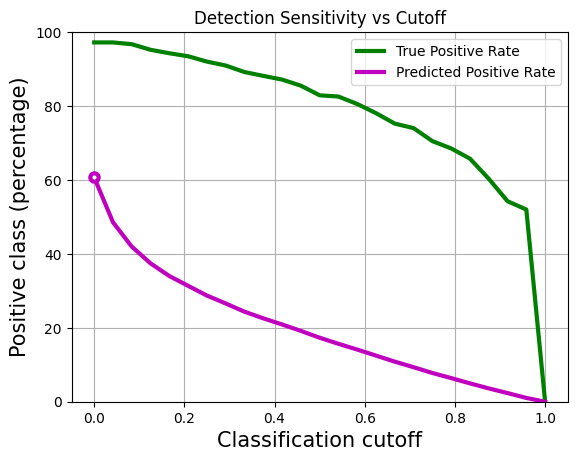

In [44]:
plt.plot(plot_range, dynamictruePosRatesAl, "g", linewidth=3, label ="True Positive Rate")
l, =plt.plot(plot_range, dynamicPredictPosRatesAl,"m", linewidth=3, label ="Predicted Positive Rate")
plt.scatter(plot_range[0], dynamicPredictPosRatesAl[0], marker='o', 
    facecolor='white',  # Change: to opaque color
    edgecolor=l.get_color(),  
    linewidth=l.get_linewidth(),  # Change: match line width
    zorder=10  # Change: raise to higher level.
    )
plt.ylim(0, 100)
plt.grid()
plt.xlabel("Classification cutoff", fontsize = 15)
plt.ylabel("Positive class (percentage)", fontsize = 15)
plt.title("Detection Sensitivity vs Cutoff")
plt.legend()
plt.savefig('detection_sensitivity_cutoff_alignn.jpg', format='jpg',
            bbox_inches='tight',dpi=400);
# ;

In [45]:
nonzero_pred_alignn = bigTdf[(bigTdf.avg_prediction_alignn>0.01) & (bigTdf.avg_prediction_alignn<0.5)]
len(nonzero_pred_alignn)/len(bigTdf)

0.4309838704586345

In [52]:
bigTdf["mid_class_pred"] = bigTdf.prediction_alignn.copy()
bigTdf.mid_class_pred[(bigTdf.avg_prediction_alignn>0.01) & (bigTdf.avg_prediction_alignn<0.5)] = 0.5

/tmp/ipykernel_3732359/3425242755.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bigTdf["mid_class_pred"] = bigTdf.prediction_alignn.copy()
/tmp/ipykernel_3732359/3425242755.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bigTdf.mid_class_pred[(bigTdf.avg_prediction_alignn>0.01) & (bigTdf.avg_prediction_alignn<0.5)] = 0.5
/tmp/ipykernel_3732359/3425242755.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

/tmp/ipykernel_3732359/3136766484.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(  sharex=ax1,)


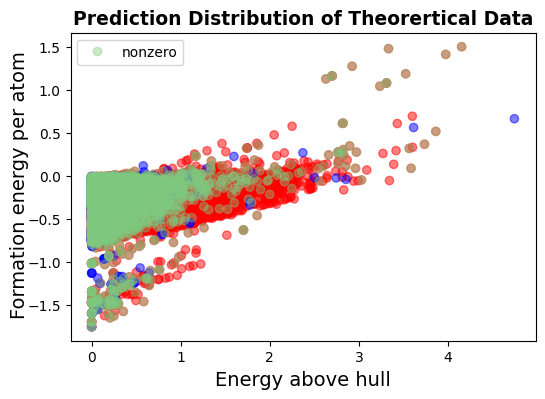

In [56]:
# data_classes_e = ['False (-) class', 'True (+) class']
data_classes_t = ['Predicted (-) class', 'Predicted (+) class']
data_classes_nonzero = ['nonzero']

colors = ListedColormap(['r','b'])
fig, ax2 = plt.subplots(1, 1, sharex=True, figsize=(6,4))

# scatter  = ax1.scatter(bigEdf.sort_values("avg_prediction_alignn", ascending=False).energy_above_hull, 
#             bigEdf.sort_values("avg_prediction_alignn", ascending=False).formation_energy_per_atom,
#             c=bigEdf.sort_values("avg_prediction_alignn", ascending=False).prediction_alignn, 
#             cmap = colors,alpha = .4)
# ax1.legend(handles=scatter.legend_elements()[0], labels=data_classes_e)

# ax1.set_title('Prediction Distribution of Experimental Data', fontsize=13.5, fontweight='bold')
# plt.tick_params('x', labelbottom=False);

ax2 = plt.subplot(  sharex=ax1,)
scatter  = plt.scatter(bigTdf.sort_values("avg_prediction_alignn", ascending=True).energy_above_hull, 
            bigTdf.sort_values("avg_prediction_alignn", ascending=True).formation_energy_per_atom,
            c=bigTdf.sort_values("avg_prediction_alignn", ascending=True).prediction_alignn, 
            cmap = colors,alpha = .5)
scatter2  = plt.scatter(nonzero_pred_alignn.sort_values("avg_prediction_alignn", ascending=False).energy_above_hull, 
            nonzero_pred_alignn.sort_values("avg_prediction_alignn", ascending=False).formation_energy_per_atom,
            c=nonzero_pred_alignn.sort_values("avg_prediction_alignn", ascending=False).prediction_alignn, 
            cmap = "Accent",alpha = .4)
ax2.legend(handles=scatter.legend_elements()[0], labels=data_classes_t)
ax2.legend(handles=scatter2.legend_elements()[0], labels=data_classes_nonzero)

ax2.set_xlabel('Energy above hull', fontsize=14)
# ax2.set_ylabel('Formation energy per atom', fontsize=12)
ax2.set_title('Prediction Distribution of Theorertical Data', fontsize=13.5, fontweight='bold');

plt.subplots_adjust(hspace=.15)
fig.text(0.04, 0.5, 'Formation energy per atom', ha='center', va='center',
         rotation='vertical', fontsize=14);

# plt.savefig('energies_labels_double.jpg', format='jpg',
plt.savefig('energies_non_negative_labels_alignn.jpg', format='jpg',
            bbox_inches='tight',dpi=400);


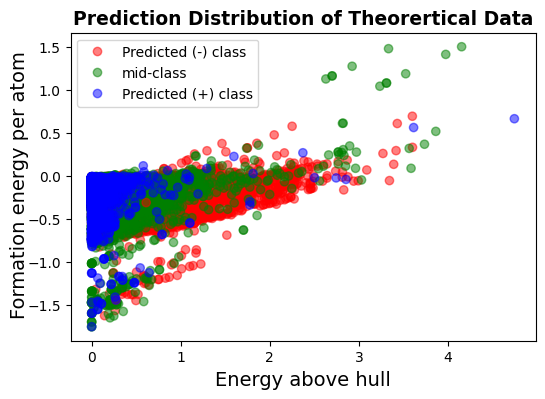

In [62]:
# data_classes_e = ['False (-) class', 'True (+) class']
data_classes_t = ['Predicted (-) class', 'mid-class', 'Predicted (+) class']
# data_classes_nonzero = ['nonzero']

colors = ListedColormap(['r','g','b'])
fig, ax2 = plt.subplots(1, 1, sharex=True, figsize=(6,4))

# scatter  = ax1.scatter(bigEdf.sort_values("avg_prediction_alignn", ascending=False).energy_above_hull, 
#             bigEdf.sort_values("avg_prediction_alignn", ascending=False).formation_energy_per_atom,
#             c=bigEdf.sort_values("avg_prediction_alignn", ascending=False).prediction_alignn, 
#             cmap = colors,alpha = .4)
# ax1.legend(handles=scatter.legend_elements()[0], labels=data_classes_e)

# ax1.set_title('Prediction Distribution of Experimental Data', fontsize=13.5, fontweight='bold')
# plt.tick_params('x', labelbottom=False);

# ax2 = plt.subplot(  sharex=ax1,)
scatter  = plt.scatter(bigTdf.sort_values("avg_prediction_alignn", ascending=True).energy_above_hull, 
            bigTdf.sort_values("avg_prediction_alignn", ascending=True).formation_energy_per_atom,
            c=bigTdf.sort_values("avg_prediction_alignn", ascending=True).mid_class_pred, 
            cmap = colors,alpha = .5)
# scatter2  = plt.scatter(nonzero_pred_alignn.sort_values("avg_prediction_alignn", ascending=False).energy_above_hull, 
#             nonzero_pred_alignn.sort_values("avg_prediction_alignn", ascending=False).formation_energy_per_atom,
#             c=nonzero_pred_alignn.sort_values("avg_prediction_alignn", ascending=False).prediction_alignn, 
#             cmap = "Accent",alpha = .4)
ax2.legend(handles=scatter.legend_elements()[0], labels=data_classes_t)
# ax2.legend(handles=scatter2.legend_elements()[0], labels=data_classes_nonzero)

ax2.set_xlabel('Energy above hull', fontsize=14)
# ax2.set_ylabel('Formation energy per atom', fontsize=12)
ax2.set_title('Prediction Distribution of Theorertical Data', fontsize=13.5, fontweight='bold');

plt.subplots_adjust(hspace=.15)
fig.text(0.04, 0.5, 'Formation energy per atom', ha='center', va='center',
         rotation='vertical', fontsize=14);

# plt.savefig('energies_labels_double.jpg', format='jpg',
# plt.savefig('energies_non_negative_labels_alignn.jpg', format='jpg',
#             bbox_inches='tight',dpi=400);


'/home/samariam/projects/chemheuristics/alignn'

Result comparison